## **Klasifikasi Audio Huruf Vokal menggunakan CNN 🎙️🧠**

In [1]:
# 1: Import library
%pip install torch librosa sounddevice soundfile matplotlib scipy

import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import librosa
import sounddevice as sd
import soundfile as sf
import matplotlib.pyplot as plt
from scipy.signal import welch

# 2: Parameters
SAMPLE_RATE = 32000
DURATION = 2  # seconds
NUM_SAMPLES = SAMPLE_RATE * DURATION
DATA_DIR = './data-suara/animal-soundprepros'
LABELS = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])
print("Detected classes:", LABELS)

Note: you may need to restart the kernel to use updated packages.
Detected classes: ['Aslan', 'Bear', 'Cat', 'Chicken', 'Cow', 'Dog', 'Dolphin', 'Donkey', 'Elephant', 'Frog', 'Horse', 'Monkey', 'Sheep']


## Menyiapkan Dataset untuk Training Model
Dataset yang digunakan akan didapatkan menggunakan rekaman suara anda secara langsung, yang mana anda akan diminta untuk merekam huruf vokal A,I,U,E,dan O sebanyak 15x setiap vokalnya.

In [2]:
# 3: Fungsi Recording untuk Merekam Data
def record_sample(vowel, idx):
    print(f"Recording {vowel} sample {idx + 1}/{5 + 10}...")
    recording = sd.rec(NUM_SAMPLES, samplerate=SAMPLE_RATE, channels=1)
    sd.wait()
    filename = os.path.join(DATA_DIR, f"{vowel}_{idx}.wav")
    sf.write(filename, recording, SAMPLE_RATE)
    return filename

# 4: Rekam Data untuk Setiap Label (misal suara hewan)
for label in LABELS:
    os.makedirs(os.path.join(DATA_DIR, label), exist_ok=True)
    for idx in range(15):  # atau jumlah sesuai keinginan
        path = record_sample(label, idx)
        target_path = os.path.join(DATA_DIR, label, os.path.basename(path))
if not os.path.exists(target_path):
    os.rename(path, target_path)
else:
    print(f"❗File {target_path} already exists. Skipping...")

Recording Aslan sample 1/15...
Recording Aslan sample 2/15...
Recording Aslan sample 3/15...
Recording Aslan sample 4/15...
Recording Aslan sample 5/15...
Recording Aslan sample 6/15...
Recording Aslan sample 7/15...
Recording Aslan sample 8/15...
Recording Aslan sample 9/15...
Recording Aslan sample 10/15...
Recording Aslan sample 11/15...
Recording Aslan sample 12/15...
Recording Aslan sample 13/15...
Recording Aslan sample 14/15...
Recording Aslan sample 15/15...
Recording Bear sample 1/15...
Recording Bear sample 2/15...
Recording Bear sample 3/15...
Recording Bear sample 4/15...
Recording Bear sample 5/15...
Recording Bear sample 6/15...
Recording Bear sample 7/15...
Recording Bear sample 8/15...
Recording Bear sample 9/15...
Recording Bear sample 10/15...
Recording Bear sample 11/15...
Recording Bear sample 12/15...
Recording Bear sample 13/15...
Recording Bear sample 14/15...
Recording Bear sample 15/15...
Recording Cat sample 1/15...
Recording Cat sample 2/15...
Recording Cat s

## Pre-processing Dataset dan Ekstraksi Fitur 🔍
Tujuan tahap ini ialah untuk menyiapkan data mentah menjadi fitur siap model. Pre-processing meliputi proses:
- **VAD** (Voice Activity Detection) untuk membuang silent segments  
- **Padding/cropping** agar durasi konsisten  
- **Normalisasi amplitudo**  
- Ekstraksi **MFCC** (40 koefisien), distandarisasi
- Membuat Custom Dataset dan Menyimpan pasangan (MFCC, label)  
- Memisahkan dataset menjadi train (10 data) dan test (5 data)
- Definisi Arsitektur CNN

In [15]:
# 5: Preprocessing Audio Preprocessing dengan VAD dan Feature Extraction
def preprocess_audio(file_path, sr=SAMPLE_RATE, num_samples=NUM_SAMPLES, top_db=20):
    y, _ = librosa.load(file_path, sr=sr)
    intervals = librosa.effects.split(y, top_db=top_db)
    if intervals.size:
        y = np.concatenate([y[start:end] for start, end in intervals])
    if len(y) < num_samples:
        y = np.pad(y, (0, num_samples - len(y)))
    else:
        y = y[:num_samples]
    max_amp = np.max(np.abs(y)) + 1e-6
    y = y / max_amp
    return y


def extract_features(file_path):
    y = preprocess_audio(file_path)
    mfcc = librosa.feature.mfcc(y=y, sr=SAMPLE_RATE, n_mfcc=40)
    mfcc = (mfcc - np.mean(mfcc)) / (np.std(mfcc) + 1e-6)
    return mfcc.astype(np.float32)

# 6: Custom Dataset
def gather_files():
    all_files = []
    for label_idx, label in enumerate(LABELS):
        files = sorted(os.listdir(os.path.join(DATA_DIR, label)))
        full = [os.path.join(DATA_DIR, label, f) for f in files if f.endswith('.wav')]
        all_files += [(f, label_idx) for f in full]
    return all_files

class VowelDataset(Dataset):
    def __init__(self, file_label_pairs):
        self.data = []
        for f, label in file_label_pairs:
            feats = extract_features(f)
            self.data.append((feats[np.newaxis, ...], label))
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        x, y = self.data[idx]
        return torch.tensor(x), torch.tensor(y)

# 7: Menyiapkan DataLoaders
files = gather_files()

train_list, test_list = [], []
for l_idx, label in enumerate(LABELS):
    fl = [p for p in files if p[1] == l_idx]
    split = int(0.8 * len(fl))
    train_list += fl[:split]
    test_list += fl[split:]
    
train_ds = VowelDataset(train_list)
test_ds = VowelDataset(test_list)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=16)

# 8: Definisikan CNN Model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )
        dummy = torch.zeros(1, 1, 40, NUM_SAMPLES // 512 + 1)
        out = self.conv(dummy)
        self.flatten_dim = out.numel() // out.shape[0]
        self.fc = nn.Linear(self.flatten_dim, len(LABELS))


    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


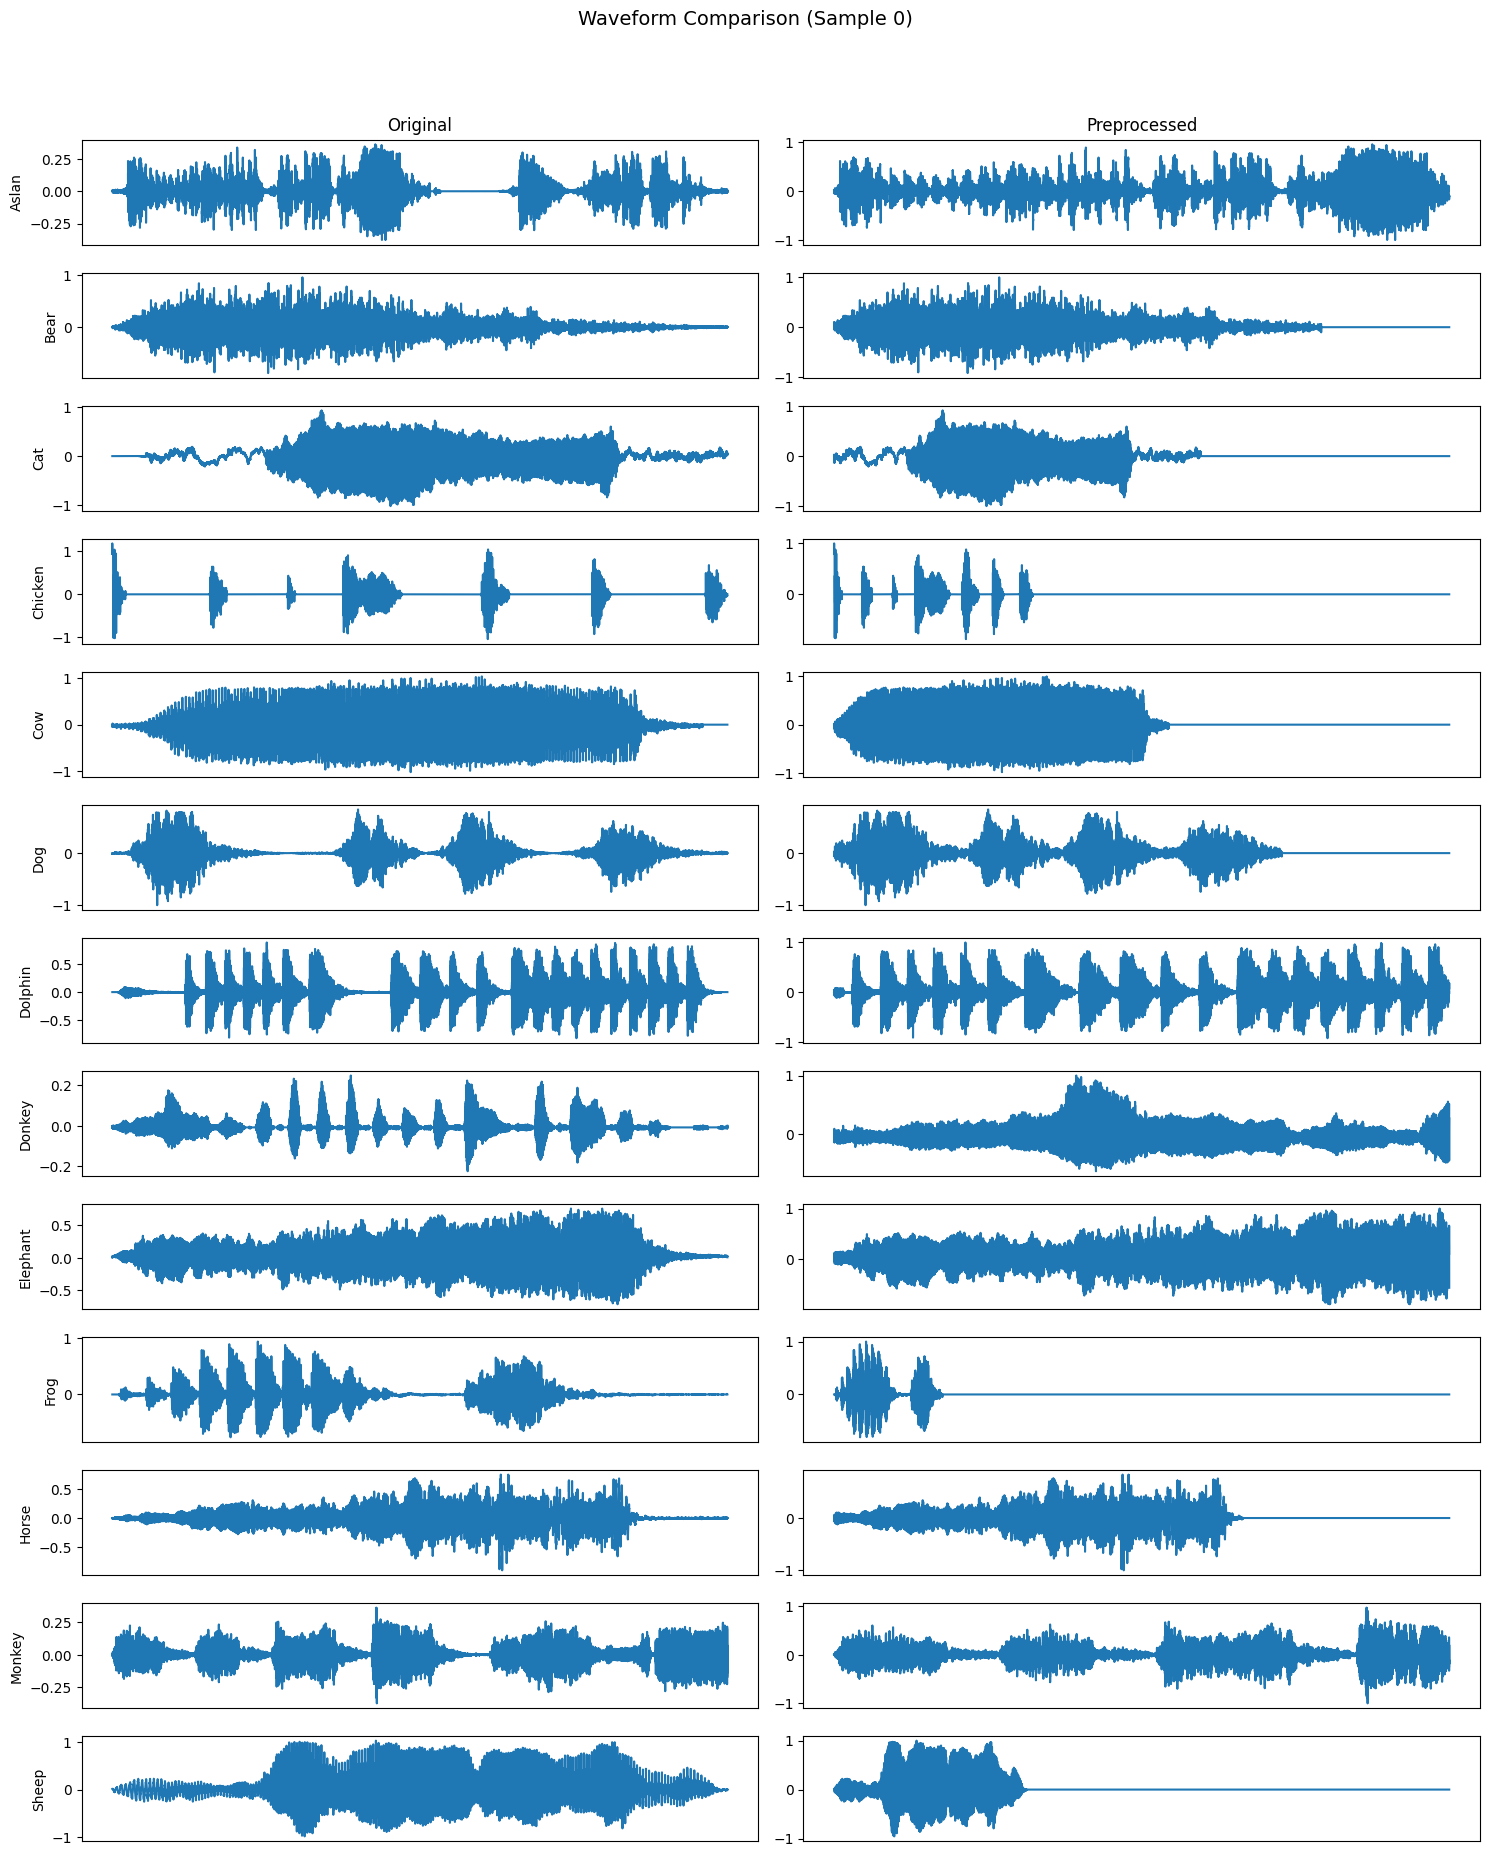

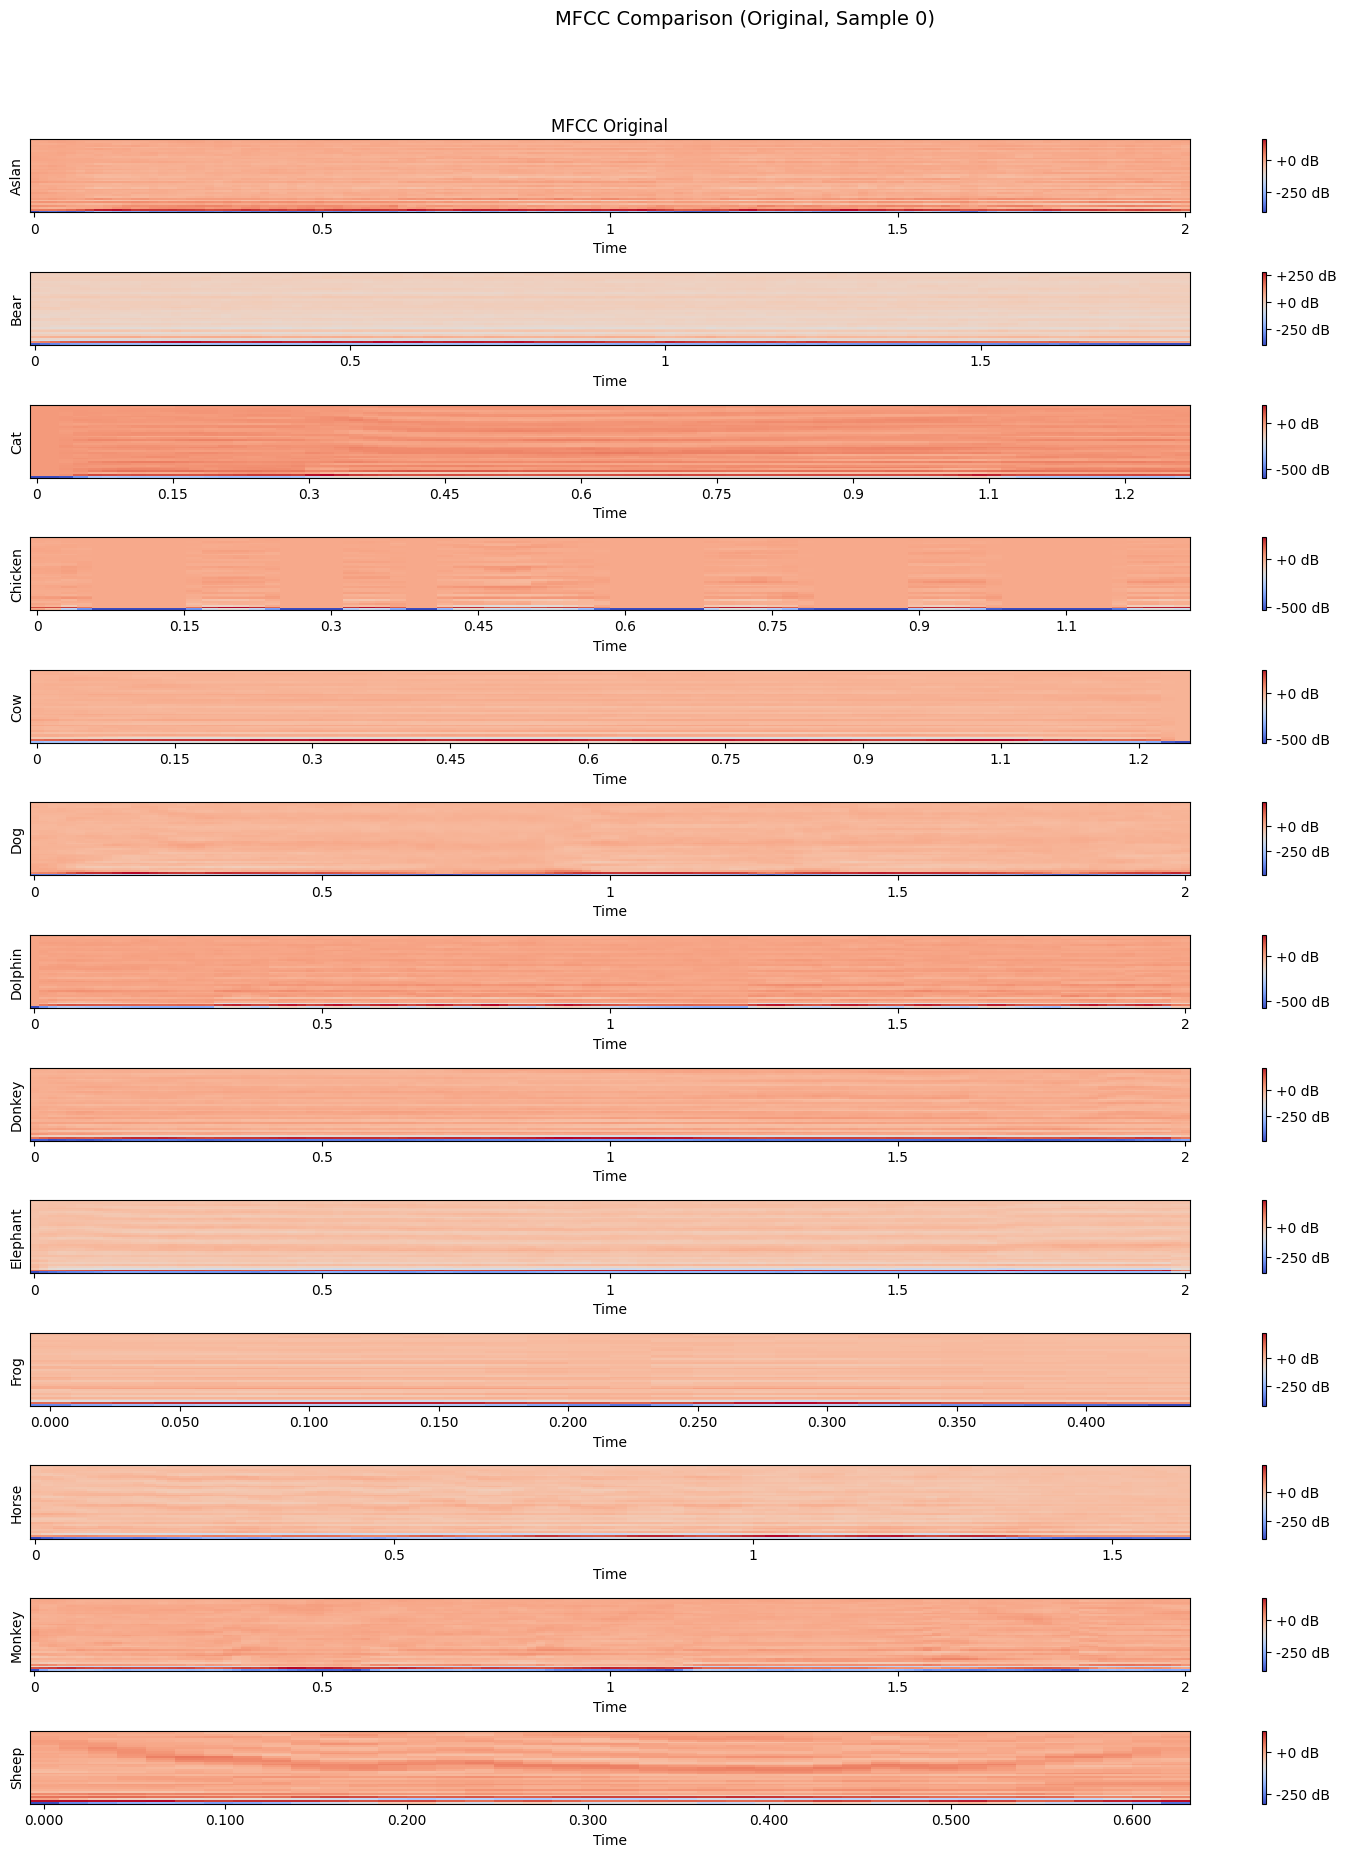

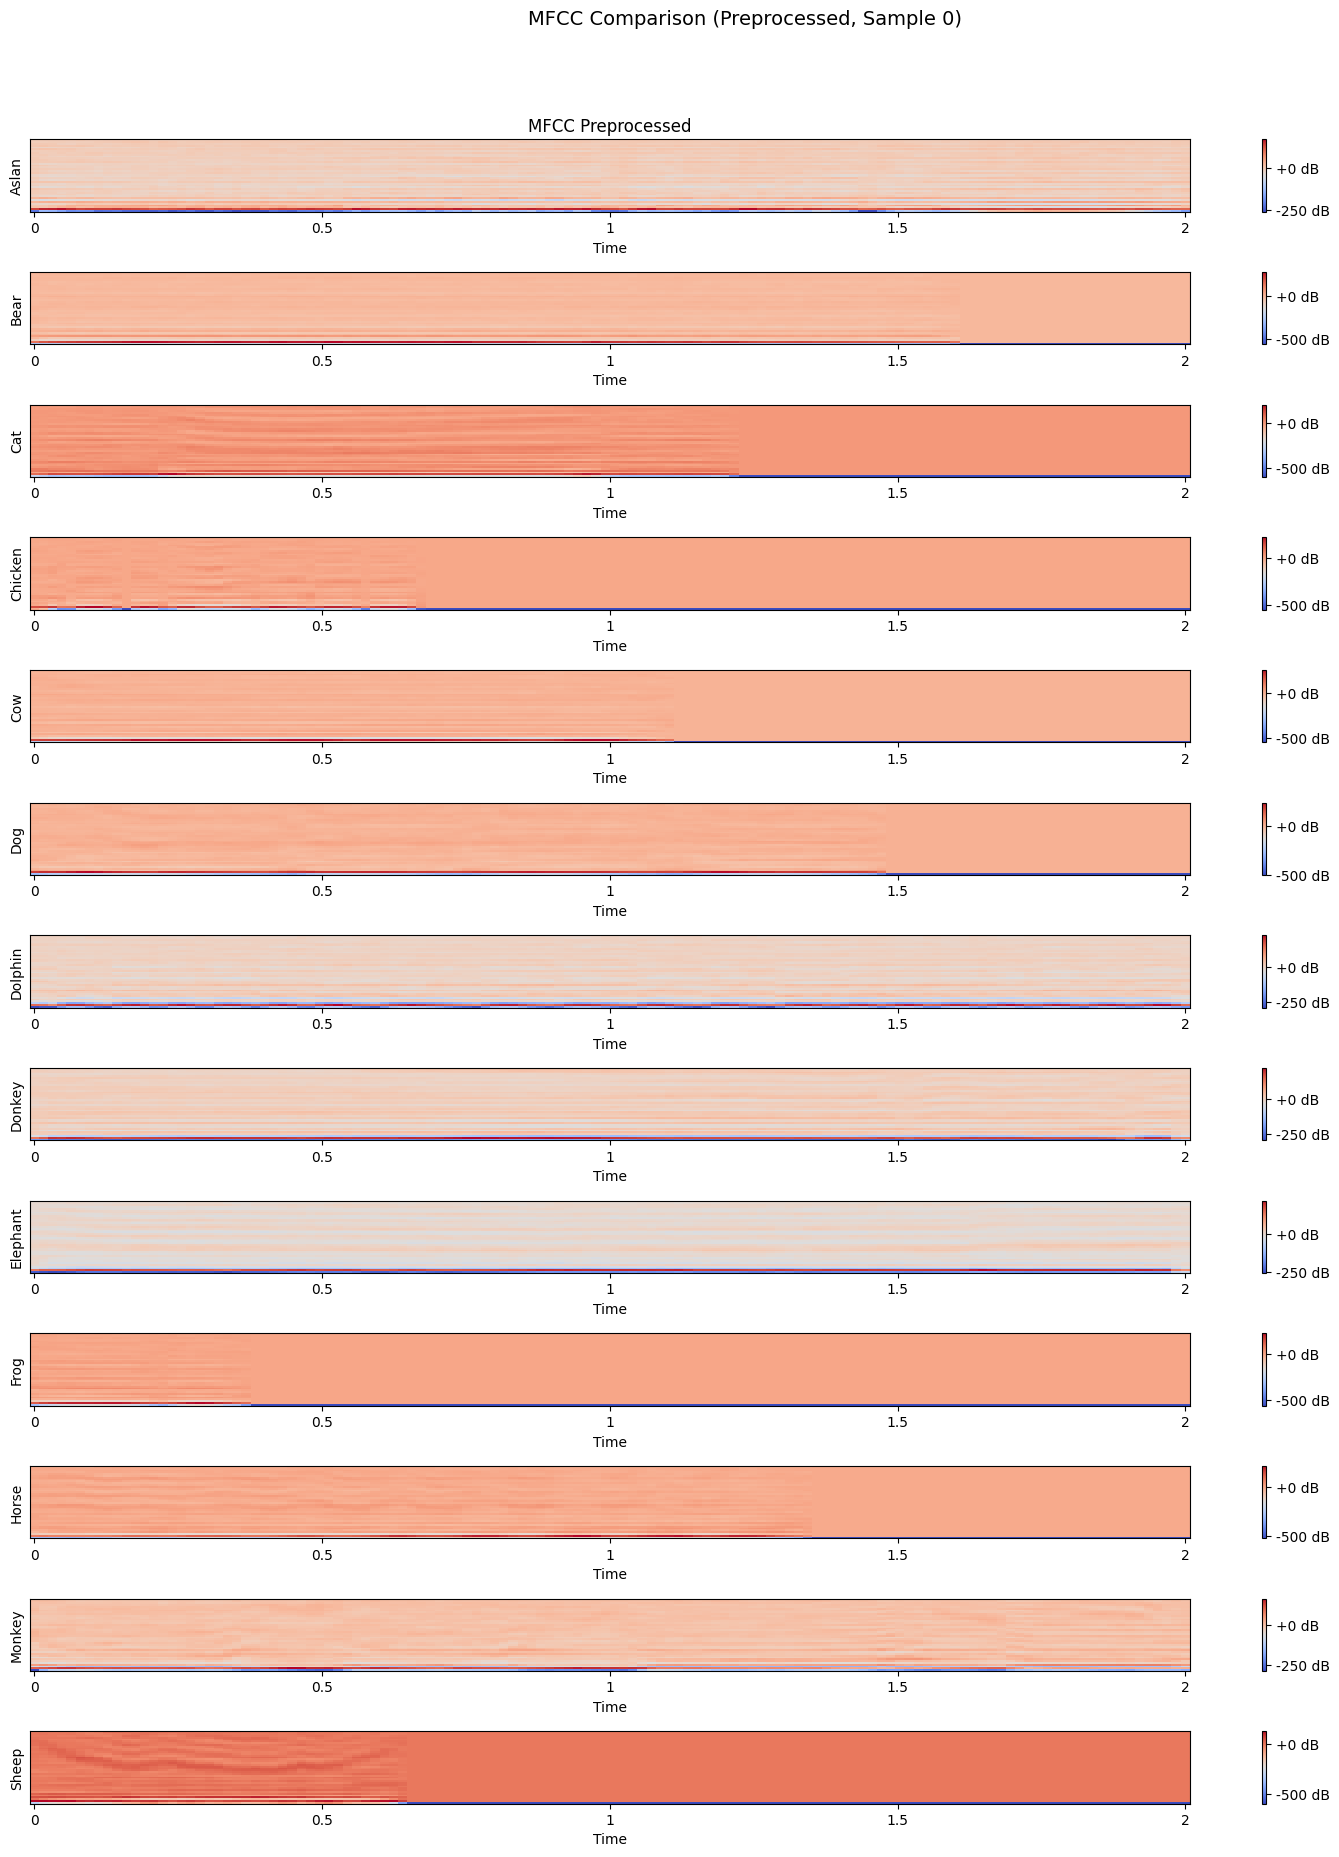

In [16]:
# Perbandingan Bentuk Gelombang dan MFCC tiap Vokal
#files_by_vowel = {v: sorted(os.listdir(os.path.join(DATA_DIR, v))) for v in LABELS}
sample_idx = 0

# Waveform Comparison
files_by_label = {v: sorted(os.listdir(os.path.join(DATA_DIR, v))) for v in LABELS}
plt.figure(figsize=(15, len(LABELS)*1.5))
for i, label in enumerate(LABELS):
    fpath = os.path.join(DATA_DIR, label, files_by_label[label][sample_idx])
    y_orig, _ = librosa.load(fpath, sr=SAMPLE_RATE)
    y_proc = preprocess_audio(fpath)

    plt.subplot(len(LABELS), 2, 2*i+1)
    plt.plot(y_orig)
    if i == 0: plt.title("Original")
    plt.ylabel(label)
    plt.xticks([])

    plt.subplot(len(LABELS), 2, 2*i+2)
    plt.plot(y_proc)
    if i == 0: plt.title("Preprocessed")
    plt.xticks([])

plt.suptitle(f"Waveform Comparison (Sample {sample_idx})", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# MFCC Comparison
for mode, y_func in [
    ("Original", lambda f: librosa.load(f, sr=SAMPLE_RATE)[0][:NUM_SAMPLES]),
    ("Preprocessed", lambda f: preprocess_audio(f))
]:
    plt.figure(figsize=(15, len(LABELS)*1.5))
    for i, label in enumerate(LABELS):
        fpath = os.path.join(DATA_DIR, label, files_by_label[label][sample_idx])
        y = y_func(fpath)
        mfcc = librosa.feature.mfcc(y=y, sr=SAMPLE_RATE, n_mfcc=40)

        plt.subplot(len(LABELS), 1, i+1)
        librosa.display.specshow(mfcc, sr=SAMPLE_RATE, x_axis='time')
        plt.colorbar(format='%+2.0f dB')
        plt.ylabel(label)
        if i == 0: plt.title(f'MFCC {mode}')
        else: plt.title('')

    plt.suptitle(f"MFCC Comparison ({mode}, Sample {sample_idx})", fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

### Sumber Referensi Frekuensi: https://biomed.papers.upol.cz/pdfs/bio/2007/02/31.pdf


🔊 Power Spectrum per Animal Class (Sample 0)


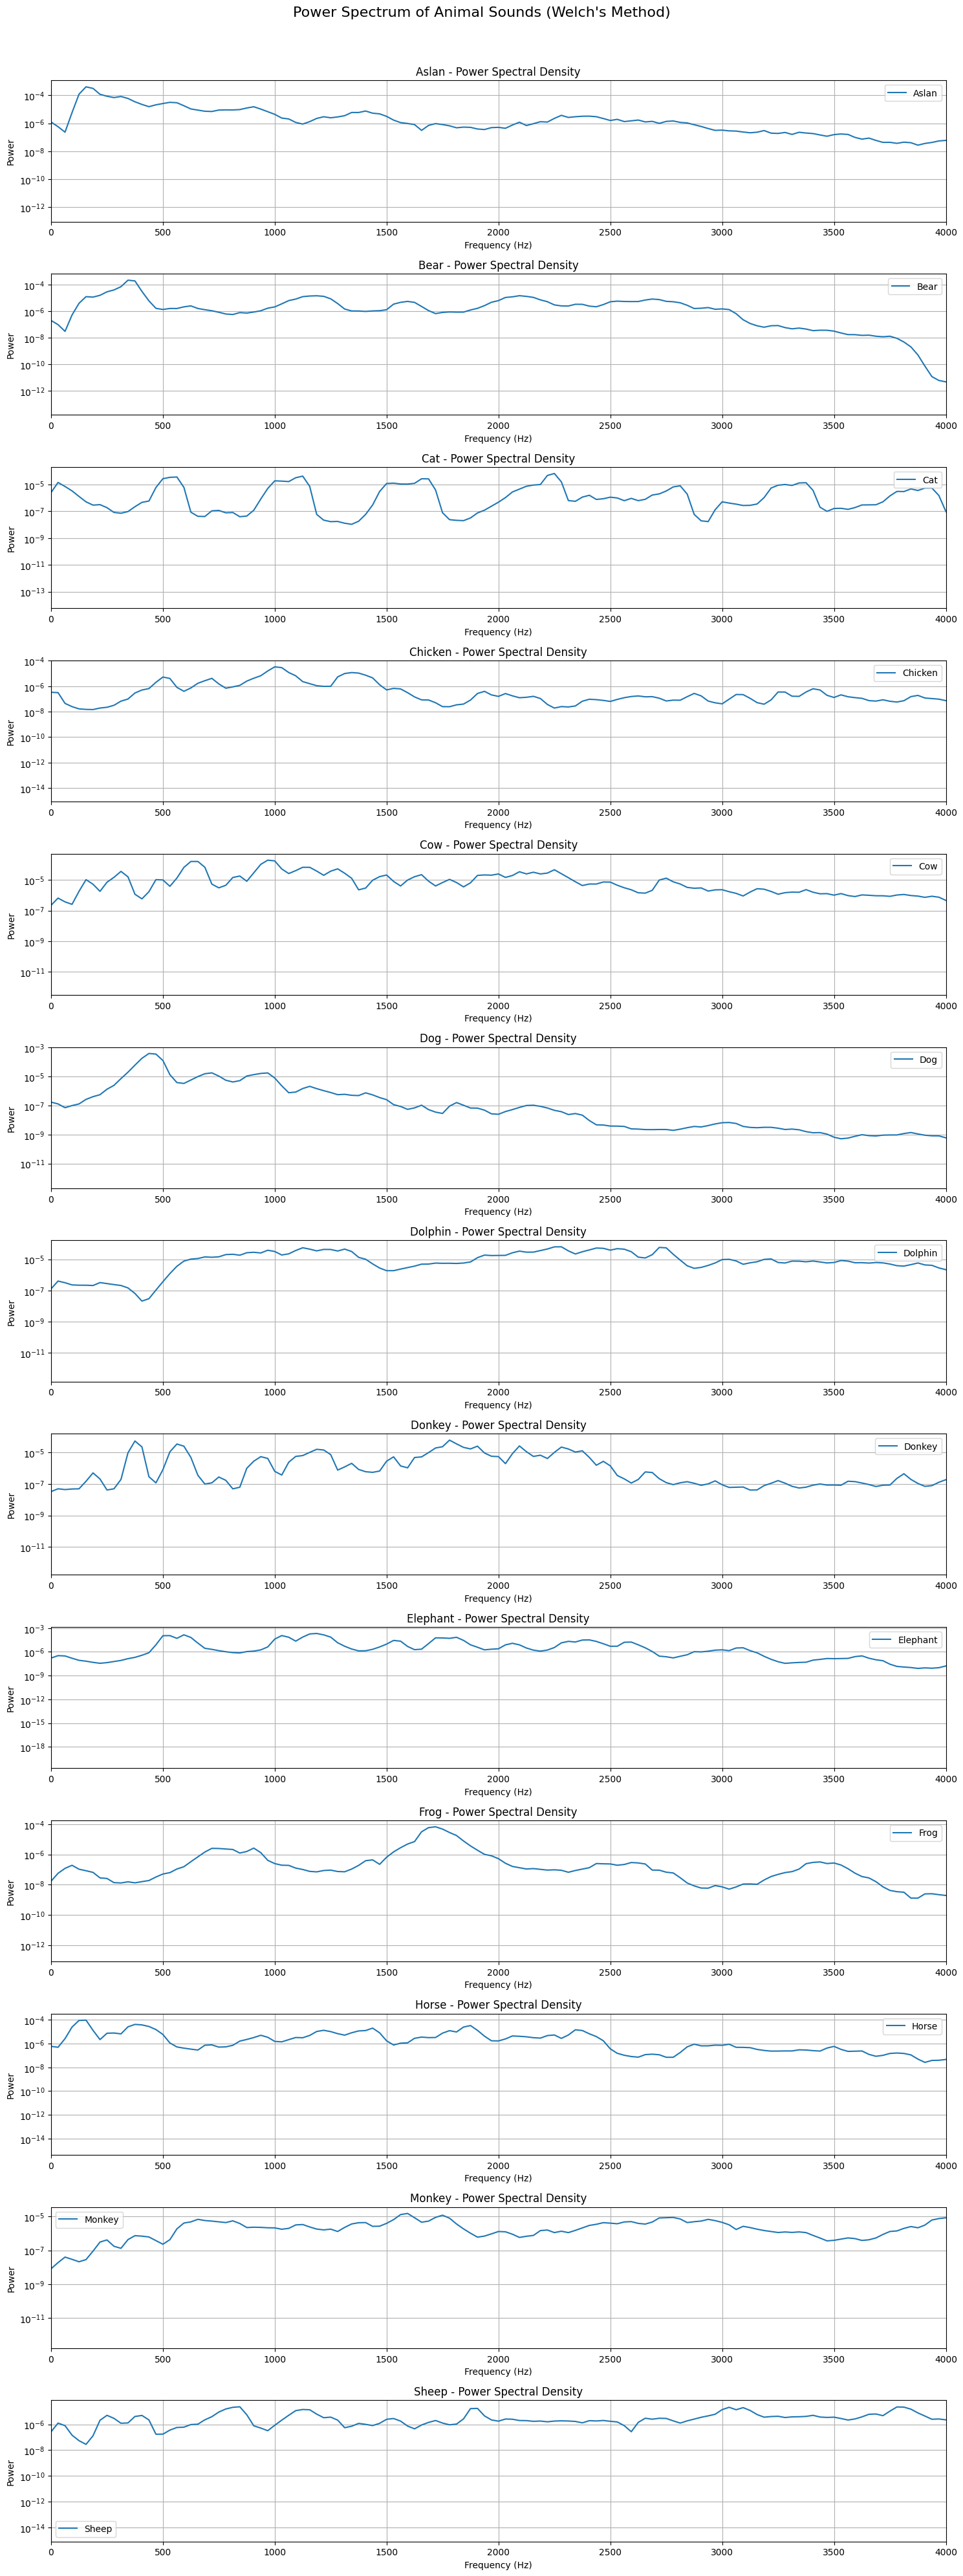

In [17]:


from scipy.signal import welch
import matplotlib.pyplot as plt
import numpy as np

# Sample plot index (bisa diganti 1–N)
sample_idx = 0  

# Buat layout figure
plt.figure(figsize=(15, len(LABELS) * 3))

print("\n🔊 Power Spectrum per Animal Class (Sample {})".format(sample_idx))

for i, label in enumerate(LABELS):
    fpath = os.path.join(DATA_DIR, label, files_by_label[label][sample_idx])
    y = preprocess_audio(fpath)

    # Hitung spektrum menggunakan Welch's method
    f, Pxx = welch(y, fs=SAMPLE_RATE, nperseg=1024)

    # Plot
    plt.subplot(len(LABELS), 1, i + 1)
    plt.semilogy(f, Pxx, label=f'{label}')
    plt.title(f'{label} - Power Spectral Density')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power')
    plt.xlim(0, 4000)  # frekuensi umum suara hewan (bisa disesuaikan)
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.suptitle("Power Spectrum of Animal Sounds (Welch's Method)", fontsize=16, y=1.02)
plt.show()


### Kesimpulan Pre-Processing Data
1. Data telah dicleaning dan dinormalisasikan (terlihat dari MFCC dan gelombang suara dimana noise telah berkurang dan ukuran panjang gelombang di normalisasikan)
2. Berdasarkan distribusi frekuensi, dataset yang digunakan telah baik, ditunjukkan pada grafik dimana frekuensi F1 dan F2 tiap vokal pada data berada dalam rentang yang seharusnya sesuai secara teoritikal nya

## **TRAINING MODEL** 📈

Using device: cuda


Epoch 1/100 - Loss: 3.3514 | Train: 19.04% | Test: 29.23%


Epoch 10/100 - Loss: 0.3173 | Train: 91.15% | Test: 65.38%


Epoch 20/100 - Loss: 0.1341 | Train: 95.38% | Test: 60.77%


Epoch 30/100 - Loss: 0.0215 | Train: 99.81% | Test: 67.69%


Epoch 40/100 - Loss: 0.0107 | Train: 100.00% | Test: 66.92%


Epoch 50/100 - Loss: 0.0319 | Train: 98.85% | Test: 63.08%


Epoch 60/100 - Loss: 0.0185 | Train: 99.81% | Test: 66.92%


Epoch 70/100 - Loss: 0.0046 | Train: 100.00% | Test: 68.46%


Epoch 80/100 - Loss: 0.0031 | Train: 100.00% | Test: 68.46%


Epoch 90/100 - Loss: 0.0023 | Train: 100.00% | Test: 70.00%

















Training Epochs: 100%|██████████| 100/100 [00:10<00:00,  9.69it/s]

Epoch 100/100 - Loss: 0.0014 | Train: 100.00% | Test: 68.46%

✅ Model terbaik disimpan (Test Acc: 70.77%)


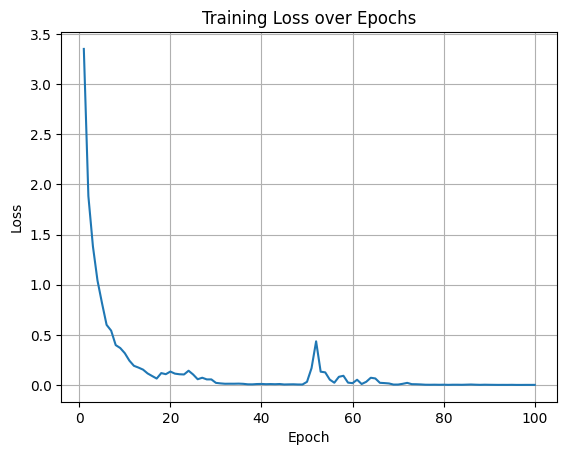

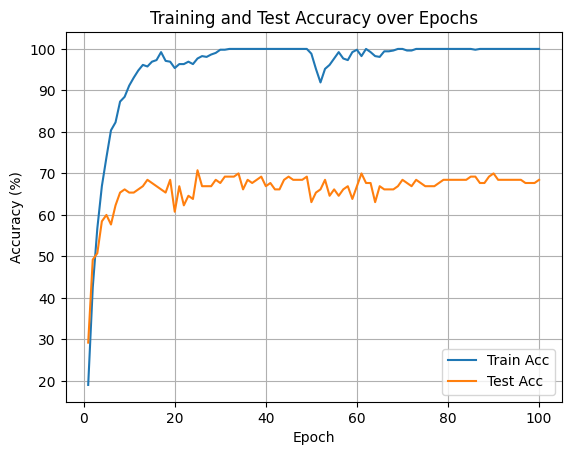

In [22]:
### 9: Training Model
import sys
from tqdm import tqdm
  # optional, bisa dihapus kalau ga suka

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 100
train_losses, train_accs, test_accs = [], [], []

# Tracking best model
best_acc = 0.0
best_model_state = None

# Training loop
for epoch in tqdm(range(epochs), desc="Training Epochs"):
    model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct_train += (preds == y).sum().item()
        total_train += y.size(0)

    avg_loss = total_loss / len(train_loader)
    train_acc = 100.0 * correct_train / total_train

    # Validation/Test
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for x_t, y_t in test_loader:
            x_t, y_t = x_t.to(device), y_t.to(device)
            out_t = model(x_t)
            preds_t = out_t.argmax(dim=1)
            correct_test += (preds_t == y_t).sum().item()
            total_test += y_t.size(0)
    test_acc = 100.0 * correct_test / total_test

    # Save metrics
    train_losses.append(avg_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    # Save best model
    if test_acc > best_acc:
        best_acc = test_acc
        best_model_state = model.state_dict()

    # Print summary every 10 epoch
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f} | Train: {train_acc:.2f}% | Test: {test_acc:.2f}%")

# Save best model
torch.save(best_model_state, "best_model_animal_sound.pth")
print(f"\n✅ Model terbaik disimpan (Test Acc: {best_acc:.2f}%)")

# Plot training loss
plt.figure()
plt.plot(range(1, epochs+1), train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid()
plt.show()

# Plot accuracy
plt.figure()
plt.plot(range(1, epochs+1), train_accs, label='Train Acc')
plt.plot(range(1, epochs+1), test_accs, label='Test Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy over Epochs')
plt.legend()
plt.grid()
plt.show()



In [24]:
from sklearn.metrics import classification_report

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

# Tampilkan test accuracy
correct = sum(p == l for p, l in zip(all_preds, all_labels))
total = len(all_labels)
print(f"Test Accuracy: {correct / total * 100:.2f}%\n")

# Tampilkan classification report
print(classification_report(all_labels, all_preds, target_names=LABELS))


Test Accuracy: 68.46%

              precision    recall  f1-score   support

       Aslan       0.73      0.80      0.76        10
        Bear       0.60      0.90      0.72        10
         Cat       0.38      0.30      0.33        10
     Chicken       0.56      0.50      0.53        10
         Cow       0.62      0.80      0.70        10
         Dog       0.60      0.60      0.60        10
     Dolphin       0.57      0.40      0.47        10
      Donkey       0.90      0.90      0.90        10
    Elephant       0.71      0.50      0.59        10
        Frog       0.77      1.00      0.87        10
       Horse       0.64      0.70      0.67        10
      Monkey       1.00      0.90      0.95        10
       Sheep       0.86      0.60      0.71        10

    accuracy                           0.68       130
   macro avg       0.69      0.68      0.68       130
weighted avg       0.69      0.68      0.68       130



In [25]:
# Cell 12: Save Model
torch.save(model.state_dict(), 'bestmodel-rawr.pth')
print("Model disimpan!")

Model disimpan!


Berdasarkan training serta evaluasi yang telah dilakukan, didapatkan model memiliki performa yang sangat baik yakni mencapai **100%** di semua evaluation metrics. Namun tentunya, mengingat dataset yang digunakan hanya sedikit, penting untuk menjadi pertimbangan pengujian kedepannya dengan menggunakan dataset yang lebih banyak dan variatif 🧮

#### **UJI COBA KLASIFIKASI SUARA VOKAL DENGAN MODEL YANG TELAH DIBUAT** 🚀

In [52]:
import torch.nn.functional as F
import sounddevice as sd
import soundfile as sf
import numpy as np

def predict_from_record():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load model
    model = CNN().to(device)
    model.load_state_dict(torch.load('bestmodel-rawr.pth', map_location=device))

    # Record audio
    print("🎙️ Silakan tirukan suara hewan... (rekaman dimulai)")
    rec = sd.rec(NUM_SAMPLES, samplerate=SAMPLE_RATE, channels=1)
    sd.wait()
    temp_path = 'temp.wav'
    sf.write(temp_path, rec, SAMPLE_RATE)

    # Extract features & convert to tensor
    feats = extract_features(temp_path)
    x = torch.tensor(feats[np.newaxis, np.newaxis, ...], dtype=torch.float32).to(device)

    # Prediction
    model.eval()
    with torch.no_grad():
        out = model(x)                     # logits
        probs = F.softmax(out, dim=1)[0]   # probs per class

    print("\n🎧 Confidence per kelas:")
    for idx, label in enumerate(LABELS):
        print(f" - {label}: {probs[idx].item()*100:.2f}%")

    pred_idx = probs.argmax().item()
    print(f"\n🔊 Prediksi: {LABELS[pred_idx]} (confidence: {probs[pred_idx].item()*100:.2f}%)")

# Contoh pemanggilan:
predict_from_record()


🎙️ Silakan tirukan suara hewan... (rekaman dimulai)

🎧 Confidence per kelas:
 - Aslan: 9.22%
 - Bear: 87.44%
 - Cat: 0.00%
 - Chicken: 0.00%
 - Cow: 1.04%
 - Dog: 0.00%
 - Dolphin: 0.04%
 - Donkey: 0.00%
 - Elephant: 0.00%
 - Frog: 0.70%
 - Horse: 1.56%
 - Monkey: 0.00%
 - Sheep: 0.00%

🔊 Prediksi: Bear (confidence: 87.44%)
